# 3D Area Projections

In [1]:
import os, sys, imio, tifffile
from skimage.io import imread, imread_collection, concatenate_images
from braintracer.braintracer import file_management as btf
from braintracer.braintracer import analysis as bt
from braintracer.braintracer import plotting as btp
import matplotlib.pyplot as plt
import numpy as np

In [2]:
## DEFINE YOUR EXPERIMENT
bt.postsyn_region = 'VTA' # You must set a starter region to use some features
# For quantifications comparing pre and postsynaptic cell populations, you must set the following:
bt.postsyn_ch = 'r' # The channel(s) containing starter cells (postsynaptics)
bt.presyn_ch = 'r' # The channel(s) containing input cells (presynaptics)
bt.presyn_regions_exclude = [''] # Presynaptic cells are the total cells in presyn_ch - (postsyn_region + presyn_regions_exclude)

bt.channel_colours = ['r','g','b'] # ordered list of colours channels will take ['r','g','b'] by default
bt.network_name = 'bt14' # default is Unet
bt.grouped = False #True # True by default, set to False if you only have one group
bt.debug = False # False by default

In [3]:
def open_image(name):
    path = f'braintracer/registered_atlases/atlas_{name}_{bt.postsyn_ch}.tiff'
    assert os.path.isfile(path), f'Please provide binarised stack coordinates at {path}'
    coordinates = imread(path)
    return coordinates

In [26]:
def _get_projection(area, dset_name, slice_details=None, padding=None, axis=0):
    if isinstance(area, list):
        areas = []
        for i in area:
            parent, children = bt.children_from(i, depth=0)
            areas = areas + [parent] + children
    else:
        area = 83 if area in ['Rostral-medial IO', 'Rostral-lateral IO', 'Caudal-medial IO', 'Caudal-lateral IO', 'Medial IO', 'Lateral IO', 'Rostral IO', 'Caudal IO'] else area
        parent, children = bt.children_from(area, depth=0)
        areas = [parent] + children
    
    reg_atlas = open_image(dset_name)
    print(reg_atlas.shape)
    if slice_details is not None:
        atlas_total = reg_atlas.shape[0]
        start = int(slice_details['start'] / slice_details['total'] * atlas_total)
        end = int(slice_details['end'] / slice_details['total'] * atlas_total)
        print(start, end)
        reg_atlas = reg_atlas[start:end,:,:]
    print(reg_atlas.shape)
    
    atlas_ar = np.isin(reg_atlas, areas)

    nz = np.nonzero(atlas_ar)
    z_min, y_min, x_min = nz[0].min(), nz[1].min(), nz[2].min()
    z_max, y_max, x_max = nz[0].max()+1, nz[1].max()+1, nz[2].max()+1
    
    if padding is not None:
        z_min, y_min, x_min = z_min - padding, y_min - padding, x_min - padding
        z_max, y_max, x_max = z_max + padding, y_max + padding, x_max + padding
    if (z_max > atlas_ar.shape[0]) or (y_max > atlas_ar.shape[1]) or (x_max > atlas_ar.shape[2]):
        print('Watch out! Remove padding for areas that touch the edge of the atlas.')
    if (z_min < 0) or (y_min < 0) or (x_min < 0):
        print('Watch out! Remove padding for areas that touch the edge of the atlas.')
    if bt.debug:
        print('x:'+str(x_min)+' '+str(x_max)+' y:'+str(y_min)+' '+str(y_max)+' z:'+str(z_min)+' '+str(z_max))
    if padding is not None:
        atlas_ar = atlas_ar[z_min : z_max,
                             y_min : y_max,
                             x_min : x_max]

    projection = atlas_ar.any(axis=2-axis)
    projection = projection.astype(int)
    projection = projection.T if axis == 0 else projection # side-on orientation does not need axis swapping
    return projection, (x_min, y_min, z_min), (x_max, y_max, z_max)

In [27]:
def full_frame(width=None, height=None):
    import matplotlib as mpl
    mpl.rcParams['savefig.pad_inches'] = 0
    figsize = None if width is None else (width, height)
    fig = plt.figure(figsize=figsize)
    ax = plt.axes([0,0,1,1], frameon=False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.autoscale(tight=True)

## Setup

In [30]:
NAME = 'SC001'
area = 1128
axis = 2
projcol = 'k'

(494, 513, 563)
139 169
(30, 513, 563)
(513, 563)


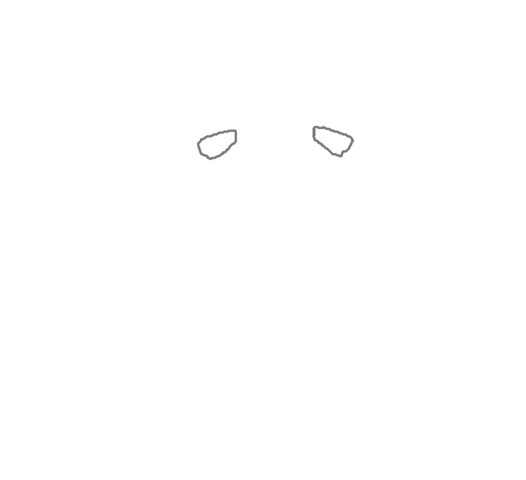

In [31]:
full_frame()
slice_details = {'start':700,
                'end':850,
                'total':2472}
projection = _get_projection(area, NAME, slice_details=slice_details, axis=axis)[0]
print(projection.shape)
#plt.imshow(projection)
plt.contour(projection, colors=projcol, alpha=0.1)
plt.gca().set_aspect('equal')
plt.gca().invert_yaxis()

start = slice_details['start']
end = slice_details['end']
btf.save(f'{NAME}_{area}_{start}-{end}', as_type='png')
plt.show()